# Neural Networks

In this exercise you will learn how to implement a feedforward neural network and train it with backpropagation.

In [1]:
import numpy as np
from numpy.random import multivariate_normal
from numpy.random import uniform
from scipy.stats import zscore

We define two helper functions "init_toy_data" and "init_model" to create a simple data set to work on and a 2 layer neural network. 

First, we create toy data with categorical labels by sampling from different multivariate normal distributions for each class. 

In [2]:
def init_toy_data(num_samples,num_features, num_classes, seed=3):
    # num_samples: number of samples *per class*
    # num_features: number of features (excluding bias)
    # num_classes: number of class labels
    # seed: random seed
    np.random.seed(seed)
    X=np.zeros((num_samples*num_classes, num_features))
    y=np.zeros(num_samples*num_classes)
    for c in range(num_classes):
        # initialize multivariate normal distribution for this class:
        # choose a mean for each feature
        means = uniform(low=-10, high=10, size=num_features)
        # choose a variance for each feature
        var = uniform(low=1.0, high=5, size=num_features)
        # for simplicity, all features are uncorrelated (covariance between any two features is 0)
        cov = var * np.eye(num_features)
        # draw samples from normal distribution
        X[c*num_samples:c*num_samples+num_samples,:] = multivariate_normal(means, cov, size=num_samples)
        # set label
        y[c*num_samples:c*num_samples+num_samples] = c
    return X,y

In [3]:
def init_model(input_size,hidden_size,num_classes, seed=3):
    # input size: number of input features
    # hidden_size: number of units in the hidden layer
    # num_classes: number of class labels, i.e., number of output units
    np.random.seed(seed)
    model = {}
    # initialize weight matrices and biases randomly
    model['W1'] = uniform(low=-1, high=1, size=(input_size, hidden_size))
    model['b1'] = uniform(low=-1, high=1, size=hidden_size)
    model['W2'] = uniform(low=-1, high=1, size=(hidden_size, num_classes))
    model['b2'] = uniform(low=-1, high=1, size=num_classes)
    return model

In [4]:
# create toy data
X,y= init_toy_data(2,4,3) # 2 samples per class; 4 features, 3 classes
# Normalize data
X = zscore(X, axis=0)
print('X: ' + str(X))
print('y: ' + str(y))

X: [[ 0.39636145  1.09468144 -0.89360845  0.91815536]
 [ 0.94419323 -0.94027869  1.22268078  1.29597409]
 [-1.41577399  1.15477931 -0.62099631  0.08323307]
 [-1.35264614 -0.13598976 -1.14221784  0.26928935]
 [ 0.9352123   0.38225626  1.419864   -1.51152157]
 [ 0.49265316 -1.55544856  0.01427781 -1.0551303 ]]
y: [0. 0. 1. 1. 2. 2.]


We now initialise our neural net with one hidden layer consisting of $10$ units and and an output layer consisting of $3$ units. Here we expect (any number of) training samples with $4$ features. We do not apply any activation functions yet. The following figure shows a graphical representation of this neuronal net. 
<img src="nn.graphviz.png"  width="30%" height="30%">

In [5]:
# initialize model
model = init_model(input_size=4, hidden_size=10, num_classes=3)

print('model: ' + str(model))
print('model[\'W1\'].shape: ' + str(model['W1'].shape))
print('model[\'W2\'].shape: ' + str(model['W2'].shape))
print('model[\'b1\'].shape: ' + str(model['b1'].shape))
print('model[\'b12\'].shape: ' + str(model['b2'].shape))
print('number of parameters: ' + str((model['W1'].shape[0] * model['W1'].shape[1]) + 
     np.sum(model['W2'].shape[0] * model['W2'].shape[1]) + 
     np.sum(model['b1'].shape[0]) +
     np.sum(model['b2'].shape[0] )))

model: {'W1': array([[ 0.10159581,  0.41629565, -0.41819052,  0.02165521,  0.78589391,
         0.79258618, -0.74882938, -0.58551424, -0.89706559, -0.11838031],
       [-0.94024758, -0.08633355,  0.2982881 , -0.44302543,  0.3525098 ,
         0.18172563, -0.95203624,  0.11770818, -0.48149511, -0.16979761],
       [-0.43294984,  0.38627584, -0.11909256, -0.68626452,  0.08929804,
         0.56062953, -0.38727294, -0.55608423, -0.22405748,  0.8727673 ],
       [ 0.95199084,  0.34476735,  0.80566822,  0.69150174, -0.24401192,
        -0.81556598,  0.30682181,  0.11568152, -0.27687047, -0.54989099]]), 'b1': array([-0.18696017, -0.0621195 , -0.46152884, -0.41641445, -0.0846272 ,
        0.72106783,  0.17250581, -0.43302428, -0.44404499, -0.09075585]), 'W2': array([[-0.58917931, -0.59724258,  0.02807012],
       [-0.82554126, -0.03282894, -0.27564758],
       [ 0.41537324,  0.49349245,  0.38218584],
       [ 0.37836083, -0.25279975,  0.33626961],
       [-0.32030267,  0.14558774, -0.34838568]

<b>Exercise 1</b>: Implement softmax layer.

Implement the softmax function given by 

### $softmax(x_i) = \frac{e^{x_i}}{{\sum_{j\in 1...J}e^{x_j}}}$, 

where $J$ is the total number of classes, i.e. the length of  **x** .

Note: Implement the function such that it takes a matrix X of shape (N, J) as input rather than a single instance **x**; N is the number of instances.

In [6]:
def softmax(X):
    exp_vals = np.exp(X)
    sum_exp_vals = np.sum(exp_vals, axis=1, keepdims=True)
    softmax_vals = exp_vals / sum_exp_vals
    return softmax_vals

Check if everything is correct.

In [7]:
x = np.array([[0.1, 0.7],[0.7,0.4]])
exact_softmax = np.array([[ 0.35434369,  0.64565631],
                         [ 0.57444252,  0.42555748]])
sm = softmax(x)
difference = np.sum(np.abs(exact_softmax - sm))
try:
    assert difference < 0.000001   
    print("Testing successful.")
except:
    print("Tests failed.")

Testing successful.


In [8]:
sm.shape

(2, 2)

<b>Exercise 2</b>: Implement the forward propagation algorithm for the model defined above.

The activation function of the hidden neurons is a Rectified Linear Unit $relu(x)=max(0,x)$ (to be applied element-wise to the hidden units)
The activation function of the output layer is a softmax function as (as implemented in Exercise 1).

The function should return both the activation of the hidden units (after having applied the $relu$ activation function) (shape: $(N, num\_hidden)$) and the softmax model output (shape: $(N, num\_classes)$). 

In [9]:
def forward_prop(X,model):
    W1=model['W1']
    b1=model['b1']
    W2=model['W2']
    b2=model['b2']
    ###############################################
    hidden_activations = np.maximum(0,np.dot(X,W1)+b1)
    probs = softmax(np.dot(hidden_activations, W2) + b2)
    ###############################################
    return hidden_activations, probs

In [10]:
acts,probs = forward_prop(X, model)
correct_probs = np.array([[0.22836388, 0.51816433, 0.25347179],
                            [0.15853289, 0.33057078, 0.51089632],
                            [0.40710319, 0.41765056, 0.17524624],
                            [0.85151353, 0.03656425, 0.11192222],
                            [0.66016592, 0.19839791, 0.14143618],
                            [0.70362036, 0.08667923, 0.20970041]])

# the difference should be very small.
difference =  np.sum(np.abs(probs - correct_probs))

try:
    assert probs.shape==(X.shape[0],len(set(y)))
    assert difference < 0.00001   
    print("Testing successful.")
except:
    print("Tests failed.")

Testing successful.


<b>Exercise 3:</b> 

How would you train the above defined neural network? Which loss-function would you use? You do not need to implement this.

<b>Part 2 (Neural Net using Keras)</b>

Instead of implementing the model learning ourselves, we can use the neural network library Keras for Python (https://keras.io/). Keras is an abstraction layer that either builds on top of Theano or Google's Tensorflow. So please install Keras and Tensorflow/Theano for this lab.

<b>Exercise 4:</b>
    Implement the same model as above using Keras:
    
    ** 1 hidden layer à 10 units
    ** softmax output layer à three units
    ** 4 input features
    
Compile the model using categorical cross-entropy (also referred to as 'softmax-loss') as loss function and using categorical crossentropy together with categorical accuracy as metrics for runtime evaluation during training.

Hint 1: Use the Sequential Class API of Keras (https://keras.io/api/models/sequential/ or https://www.tensorflow.org/guide/keras/sequential_model)

Hint 2: You can use the Adam optimizer of Keras for the model compilation

In [12]:
import os
import tensorflow as tf

# Rest of your code

In [13]:
from keras.models import Model
from keras.layers import Input, Dense

# Define the model architecture
################################################
inputs = Input(shape=(X.shape[1],))
hidden = Dense(10, activation='relu', name='Hidden_Layer')(inputs)
output = Dense(3, activation='softmax', name='Final_Layer')(hidden)

model = Model(inputs=inputs, outputs=output)
################################################

# Compile the model
################################################
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
################################################

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 Hidden_Layer (Dense)        (None, 10)                50        
                                                                 
 Final_Layer (Dense)         (None, 3)                 33        
                                                                 
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


The description of the current network can always be looked at via the summary method. The layers can be accessed via model.layers and weights can be obtained with the method get_weights. Check if your model is as expected. 

In [15]:
# Check model architecture and initial weights.
W_1, b_1 = model.layers[1].get_weights()
print("First layer weights: %s; shape: %s" % (W_1,W_1.shape))
print("First layer bias: %s; shape: %s" % (b_1,b_1.shape))
W_2, b_2 = model.layers[2].get_weights()
print("Second layer weights: %s; shape: %s" % (W_2,W_2.shape))
print("Second layer bias: %s; shape: %s" % (b_2,b_2.shape))
print("number of layes: " + str(len(model.layers)))
model.summary()

First layer weights: [[-0.5651259  -0.20433     0.45990098  0.18942297  0.4406742  -0.10213369
   0.4586246   0.40635514  0.32672685 -0.46568662]
 [-0.3672455   0.11177224 -0.62255114  0.2945583  -0.18198457  0.15555996
   0.5881398   0.39063966 -0.41717255  0.18291032]
 [-0.3703877  -0.42460796 -0.46447074  0.02396786  0.09293145  0.3156758
  -0.02932227  0.3382488  -0.5498054  -0.11193842]
 [-0.01307338  0.61262333  0.41437852 -0.04776162  0.11645871 -0.42069548
  -0.61116606  0.2479049   0.60212326  0.16359085]]; shape: (4, 10)
First layer bias: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]; shape: (10,)
Second layer weights: [[-0.02877361  0.03660959  0.22494024]
 [-0.32835874  0.2879873   0.48327267]
 [ 0.42902398  0.01777303 -0.29487297]
 [ 0.6640779   0.45882714  0.30185568]
 [ 0.4933145   0.46283293  0.5993495 ]
 [-0.24955085 -0.5077888   0.31627226]
 [ 0.44583845  0.58992445 -0.31920463]
 [-0.17304975  0.02863288 -0.06941342]
 [-0.34623334  0.12324095 -0.25305012]
 [-0.03196728  0.43796575 

<b>Exercise 5:</b> Train the model on the toy data set generated below: 

Hints: 

* Keras expects one-hot-coded labels 

* Don't forget to normalize the data

In [16]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

X, y = init_toy_data(1000,4,3, seed=3)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=67)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)
num_classes = len(np.unique(y_train_encoded))

onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))

##################################
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), epochs=10, batch_size=32)
##################################

KeyboardInterrupt: 

Compare the test accuracy with the train accuracy. What can you see? Is the model performing well?

In [21]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

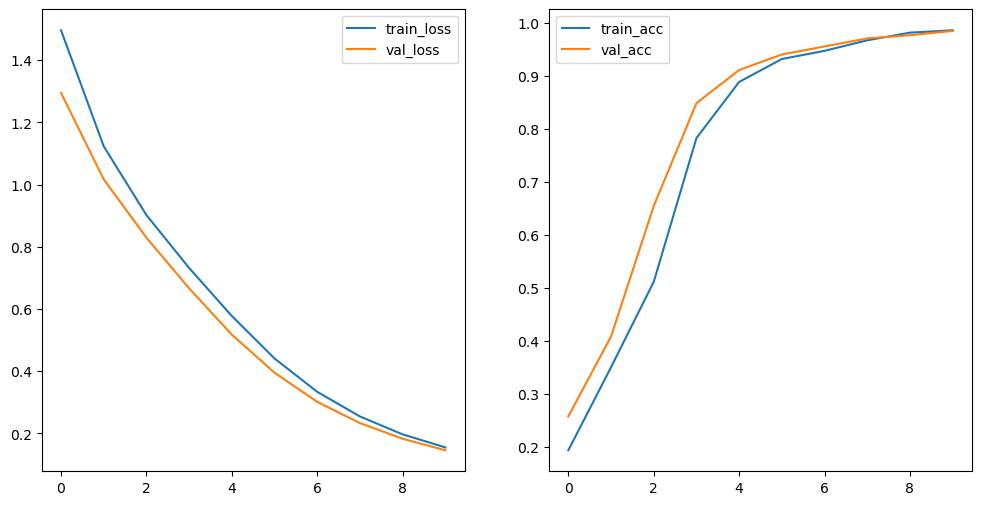

In [27]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize = (12,6))
axs = axs.ravel()
axs[0].plot(train_loss, label = 'train_loss')
axs[0].plot(val_loss,label = 'val_loss')
axs[0].legend()


axs[1].plot(train_acc, label = 'train_acc')
axs[1].plot(val_acc,label = 'val_acc')
axs[1].legend()
plt.show()